# Notbook 1: Import and Preprocessing Pipeline and Initial Fit #

In this notebook, I set up a pipeline to import and preprocess the image data and perform an initial fit to ensure that everything is working.  The fit performs well enough to give me high confidence that I can use a convolutional neural network to identify falling snow in an image.  I save the model, its training history, and its predictions.  I also import a single image and use the trained model to predict whether there is snow in that image, a necessary process for later deployment.

In [1]:
# Common data science imports used in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic Python libraries used in this notebook
import time
import datetime
import os
import json

# A custom script I wrote to easily calculate and display classification metrics
import metrictools_snow as mts

# Tensorflow libraries for importing and preprocessing images
from tensorflow import io
from tensorflow import strings
from tensorflow import argmax
from tensorflow.data import AUTOTUNE
from tensorflow.data import Dataset
from tensorflow.image import resize_with_pad

# Building neural nets and loading saved models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

### Section I: Importing and Preprocessing Images as Tensorflow Datasets ###

This [tutorial](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control) was very useful for accomplishing this in a way that allowed me to handle a very large amount of data on a personal computer.

In [2]:
def get_image(file_path):
    
    # Given a Tensorflow filepath object, sets label to 0 if the second to last part of the path is 'clear' and 1 if it is 'snow'.
    parts = strings.split(file_path, os.path.sep)
    label = parts[-2] == ['clear', 'snow']
    
    # Reads in the image at the given filepath, which should be a jpeg.
    img = io.read_file(file_path)
    img = io.decode_jpeg(img)
    
    # Add buffer as necessary to resize image to 640x640 without changing aspect ratio.
    # 640 is the largest dimesion of any image in the dataset.
    img = resize_with_pad(img, 640, 640)
    
    # Normalize images so each pixel is in the range -1 to 1
    return (img - 127.5) / 127.5, argmax(label)

In [3]:
def get_data(img_folder_list, shuffle_seed, train_size=0.8):
    
    # Gets paths to all the files in the given folders holding the training data.  No shuffling is done yet.
    file_groups = [Dataset.list_files(folder+'*', shuffle=False) for folder in img_folder_list]
    
    # Will not run unless at least 2 data folders are passed, as folder names are used to determine image labels.
    if len(file_groups) > 1:
    
        # Join the filepaths from each folder into one variable.
        for i in range(1, len(file_groups)):
            image_paths = file_groups[0].concatenate(file_groups[i])

        # Filepaths are now shuffled.  This will be redone for each training epoch.
        # It's important to do the shuffling now, before images are read into memory.
        image_paths = image_paths.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True, seed=shuffle_seed)
    
        # Train/Test/Split based on train_size, which gives the proportion of images that should be used for training.
        train_paths = image_paths.take(int(len(image_paths)*train_size))
        val_paths = image_paths.skip(int(len(image_paths)*train_size))
    
        # Use the get_image function import the images, which are resized and normalized as they are imported.
        train_images = train_paths.map(get_image, num_parallel_calls=AUTOTUNE)
        val_images = val_paths.map(get_image, num_parallel_calls=AUTOTUNE)
        return train_images, val_images
    
    # If fewer than 2 folders were given, print the message below and return no data.
    else:
        print('Only one class found.  No data returned.')
        return None

In [4]:
# Execute the above functions to create Tensorflow Dataset objects for training.
folders = ['../data/train/clear/', '../data/train/snow/']
train_data, val_data = get_data(folders, shuffle_seed=632, train_size=0.8)

### Section II: Initial model: "test1" ###

In [5]:
# Save an unbatched version of the data, which will make it easier to generate predictions and calculate metrics with them.
train_data_unbatched = train_data
val_data_unbatched = val_data

# Create batches for training and tell Tensorflow to fetch the next batch while each batch is being fit.
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

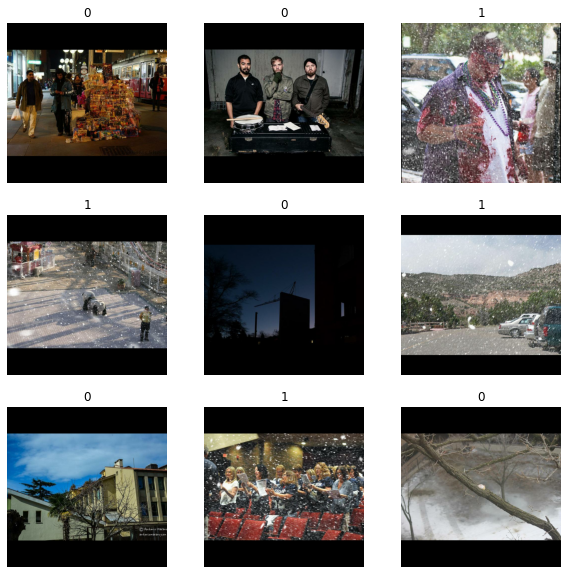

In [6]:
# Visualize a few of the pictures in the data set, along with their labels, to make sure it all looks good.
# First line gets the first batch of data.
image_batch, label_batch = next(iter(val_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # To display the image, the scaling of each pixel to the range [-1, 1] must be reversed.
    image = image_batch[i].numpy() * 127.5 + 127.5
    plt.imshow(image.astype("uint8"))
    # The label corresponding to each picture is taken as the title.
    label = label_batch[i]
    plt.title(label.numpy())
    plt.axis("off")

In [7]:
# Use a Sequential neural net.
# This is a simple model used to ensure everything is working.
# The neural net is kept fairly small with basic hypterparameter and activation values.

model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(5, 5),
                        strides=(2, 2),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Conv2D(filters=8, kernel_size=(5,5),
                       strides=(2,2),
                       activation='leaky_relu',
                       padding='same'))

model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='leaky_relu'))

model.add(layers.Dense(8, activation='leaky_relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [9]:
history = model.fit(train_data, validation_data=val_data, epochs=5, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 309s 121ms/step - loss: 0.1600 - accuracy: 0.9353 - val_loss: 0.0648 - val_accuracy: 0.9779
Epoch 2/5
2500/2500 [==============================] - 297s 119ms/step - loss: 0.0745 - accuracy: 0.9736 - val_loss: 0.0477 - val_accuracy: 0.9827
Epoch 3/5
2500/2500 [==============================] - 302s 121ms/step - loss: 0.0612 - accuracy: 0.9780 - val_loss: 0.0363 - val_accuracy: 0.9864
Epoch 4/5
2500/2500 [==============================] - 299s 120ms/step - loss: 0.0485 - accuracy: 0.9828 - val_loss: 0.0294 - val_accuracy: 0.9894
Epoch 5/5
2500/2500 [==============================] - 298s 119ms/step - loss: 0.0415 - accuracy: 0.9849 - val_loss: 0.0356 - val_accuracy: 0.9857


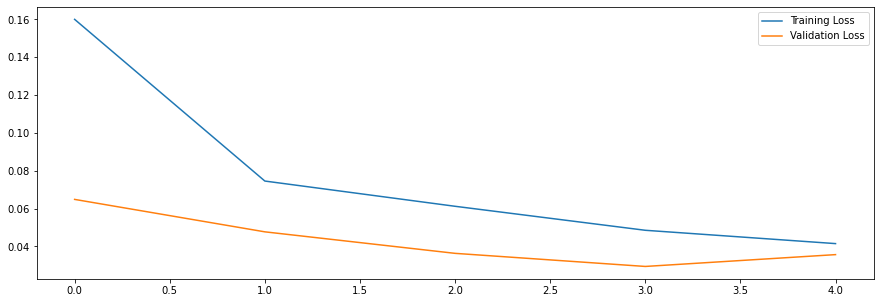

In [10]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

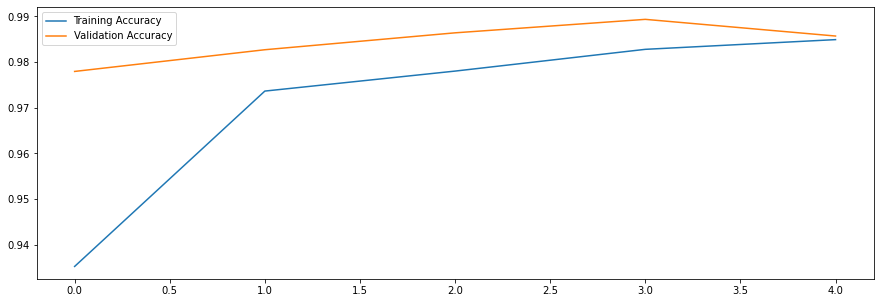

In [11]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

Considering this is a small CNN with simple hyperparameter choices, this is a very encouraging result.

### Section III: Save model, training history, predictions, and labels ###

In [12]:
model_name = 'test1'

In [13]:
model.save(f'../saved_models/{model_name}')

INFO:tensorflow:Assets written to: ../saved_models/test1\assets


This [link](https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history) showed me how to save the training history.

In [14]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}_hist', 'w'))

The following function iterates through the given dataset and saves corresponding true and predicted values for the purpose of calculating metrics. I used this [link](https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory) as a starting point to help write the code.  This process is not very efficient, so the predictions are saved to csv files once they are calculated.

In [15]:
def get_preds(dataset, model_name, which_data):

    # Generating predictions on the data takes a while, so updates will be printed.
    # t_start saves the time that prediction generation began so the updates can include time elapsed.
    t_start = time.time()
    # Count and total are also used to inform the user of progress.
    count = 0
    total = len(dataset)
    
    preds = np.array([])
    true = np.array([])
    # Iterate through each image in the given dataset and corresponding label.
    for image, label in dataset:
        # Save the predicted and true label for each image in a numpy array.
        preds = np.concatenate([preds, np.array([int(np.round(model.predict(image[np.newaxis, :]), 0))])])
        true = np.concatenate([true, np.array([label.numpy()])])
        count += 1
        # Update the user after every 1000 predictions.
        if count % 1000 == 0:
            print(f'Calculated {count} of {total} predictions ({round(count * 100 / total, 2)}%) for {which_data} data. '
                  f'{datetime.timedelta(seconds=time.time()-t_start)} elapsed.')
    
    # Save the predictions and labels to a dataframe and then output them to a csv.
    df = pd.DataFrame(zip(true, preds), columns=['true', 'pred'])
    df.to_csv(f'../saved_models/{model_name}_{which_data}.csv', index=False)   
    
    # Return the predictions and labels in numpy arrays.
    return preds, true

In [16]:
# Obtain predictions and labels for validation data.
val_preds, val_true = get_preds(val_data_unbatched, model_name, 'val')

Calculated 1000 of 20000 predictions (5.0%) for val data. 0:00:54.901386 elapsed.
Calculated 2000 of 20000 predictions (10.0%) for val data. 0:01:46.424993 elapsed.
Calculated 3000 of 20000 predictions (15.0%) for val data. 0:02:37.259921 elapsed.
Calculated 4000 of 20000 predictions (20.0%) for val data. 0:03:28.303512 elapsed.
Calculated 5000 of 20000 predictions (25.0%) for val data. 0:04:18.848108 elapsed.
Calculated 6000 of 20000 predictions (30.0%) for val data. 0:05:10.006900 elapsed.
Calculated 7000 of 20000 predictions (35.0%) for val data. 0:06:00.641834 elapsed.
Calculated 8000 of 20000 predictions (40.0%) for val data. 0:06:51.438763 elapsed.
Calculated 9000 of 20000 predictions (45.0%) for val data. 0:07:42.273586 elapsed.
Calculated 10000 of 20000 predictions (50.0%) for val data. 0:08:33.150074 elapsed.
Calculated 11000 of 20000 predictions (55.0%) for val data. 0:09:23.988935 elapsed.
Calculated 12000 of 20000 predictions (60.0%) for val data. 0:10:14.641580 elapsed.
Ca

In [17]:
# Obtain predictions and labels for training data.
train_preds, train_true = get_preds(train_data_unbatched, model_name, 'train')

Calculated 1000 of 80000 predictions (1.25%) for train data. 0:00:51.092292 elapsed.
Calculated 2000 of 80000 predictions (2.5%) for train data. 0:01:40.868819 elapsed.
Calculated 3000 of 80000 predictions (3.75%) for train data. 0:02:30.761971 elapsed.
Calculated 4000 of 80000 predictions (5.0%) for train data. 0:03:20.969316 elapsed.
Calculated 5000 of 80000 predictions (6.25%) for train data. 0:04:10.835896 elapsed.
Calculated 6000 of 80000 predictions (7.5%) for train data. 0:05:00.307909 elapsed.
Calculated 7000 of 80000 predictions (8.75%) for train data. 0:05:50.288856 elapsed.
Calculated 8000 of 80000 predictions (10.0%) for train data. 0:06:40.124133 elapsed.
Calculated 9000 of 80000 predictions (11.25%) for train data. 0:07:31.150259 elapsed.
Calculated 10000 of 80000 predictions (12.5%) for train data. 0:08:22.181995 elapsed.
Calculated 11000 of 80000 predictions (13.75%) for train data. 0:09:13.212008 elapsed.
Calculated 12000 of 80000 predictions (15.0%) for train data. 0:

### Section IV: Load the saved model and check its metrics. ###

In [7]:
load_model_name = 'test1'

In [8]:
new_model = load_model(f'../saved_models/{load_model_name}')

In [9]:
new_history_dict = json.load(open(f'../saved_models/{load_model_name}_hist', 'r'))

In [11]:
train_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_train.csv')
val_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_val.csv')

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9775    0.9932    0.9853     40052
        snow     0.9931    0.9771    0.9850     39948

    accuracy                         0.9851     80000
   macro avg     0.9853    0.9851    0.9851     80000
weighted avg     0.9853    0.9851    0.9851     80000

ROC AUC score: 0.9851395098857718

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9781    0.9932    0.9856     10054
        snow     0.9931    0.9775    0.9852      9946

    accuracy                         0.9854     20000
   macro avg     0.9856    0.9854    0.9854     20000
weighted avg     0.9855    0.9854    0.9854     20000

ROC AUC score: 0.9853574530233301

*************************



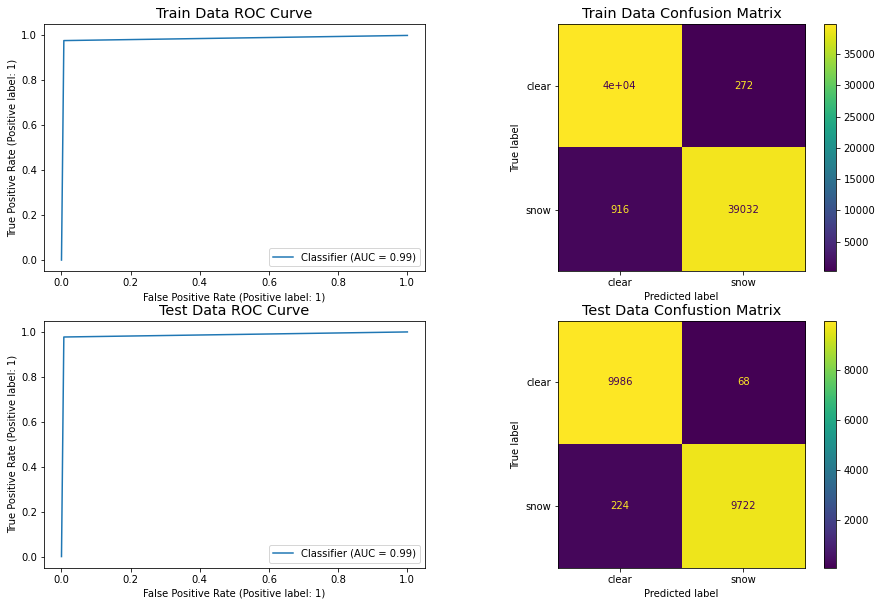

In [13]:
mts.check_metrics(train_pred_df['pred'], val_pred_df['pred'], train_pred_df['true'], val_pred_df['true'], 'clear', 'snow')

All metrics are nearly identical on the training and validaton data.  Precision is higher than recall when predicting an image has snow, suggesting that the model is more likely incorrectly predict a clear image than a snowy image.  The confusion matrices also show this fact, as we see more images incorrectly predicted to be clear than we see images incorrectly predicted to be snowy.

In the future, I will save the predictions to csv with their full decimal accuracy, rather than rounding.  This will allow me to easily check the impact of different certainty thresholds on the classification metrics.  Specifically, I can see if it is possible to shift precision and recall without negatively impacting overall accuracy or F1 score.  I think that for most applications, it will be more useful to have a higher recall when predicting snow.

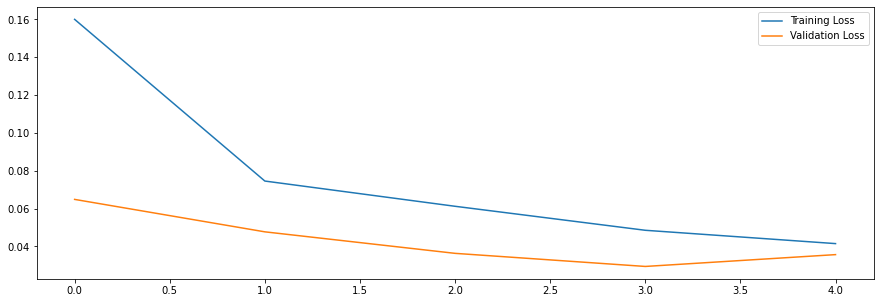

In [14]:
plt.figure(figsize=(15,5))
plt.plot(new_history_dict['loss'], label='Training Loss')
plt.plot(new_history_dict['val_loss'], label='Validation Loss')
plt.legend();

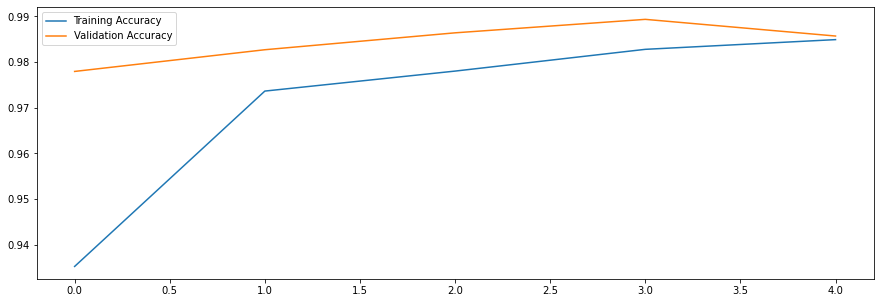

In [15]:
plt.figure(figsize=(15,5))
plt.plot(new_history_dict['accuracy'], label='Training Accuracy')
plt.plot(new_history_dict['val_accuracy'], label='Validation Accuracy')
plt.legend();

### Section V: Predict the Class of Single Images ###

The saved model is used to predict the classes of single images that are not imported as part of a Tensorflow dataset.  This will be necessary for deployment.

In [16]:
# Import the images and perform the same resizing and normalization that were performed on the training data.

test_snow_raw = io.read_file('../data/train/snow/beautiful_smile_00001.jpg')
test_clear_raw = io.read_file('../data/train/clear/beautiful_smile_00001.jpg')

test_snow_raw = io.decode_jpeg(test_snow_raw)
test_clear_raw = io.decode_jpeg(test_clear_raw)

test_snow_raw = resize_with_pad(test_snow_raw, 640, 640)
test_clear_raw = resize_with_pad(test_clear_raw, 640, 640)

test_snow = (test_snow_raw - 127.5) / 127.5
test_clear = (test_clear_raw - 127.5) / 127.5

# It is necessary to add an axis where the original data had an axis representing the batch it was in.
test_snow = test_snow[np.newaxis, :]
test_clear = test_clear[np.newaxis, :]

Although my method differs somewhat, I used this [link](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) to help me alter a single input image so I could generate a prediction on it.

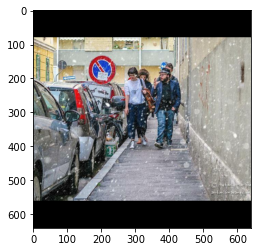

In [17]:
plt.imshow(test_snow_raw.numpy().astype("uint8"));

In [18]:
predict_snow = new_model.predict(test_snow)[0][0]
predict_snow

0.9999789

In [19]:
if round(predict_snow, 0) == 1:
    print('snow')
else:
    print('clear')

snow


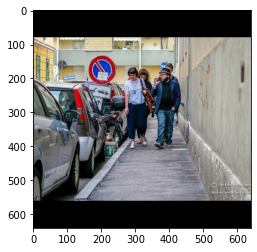

In [20]:
plt.imshow(test_clear_raw.numpy().astype("uint8"));

In [21]:
predict_clear = new_model.predict(test_clear)[0][0]
predict_clear

0.0051075662

In [22]:
if round(predict_clear, 0) == 1:
    print('snow')
else:
    print('clear')

clear


This demonstrates the process that can be used to make predictions with this neural net on new images.

I have done the following in this notebook:
- Read in 100,000 images of different sizes and classified them with a simple CNN.
- Despite the fact that my purpose was to confirm the procedure worked and I did not tune hyperparameters, the CNN already demonstrates very high accuracy in classifying the images as snowy or clear.
- I generated predictions paired with true labels so classification metrics like F1 score, Precision, and Recall could be calculated.
- I saved the model, its training history, and the predictions and labels for future reference.
- I used the saved model to generate a prediction of snowy or clear on a single image that was not imported as a Tensorflow dataset, showing promise for future deployment.

Next steps include:
- Deploy this model in a streamlit app to make predictions on uploaded images, and then hopefully videos and live webcams via API.
- Further tune the model by hyperparameter gridsearching to maximize effectiveness.  Also experiment with pruning and quantization to reduce model size and increase speed.
- If time allows, try to implement a GAN to create snow-free versions of the images.